# Test DataTransformer

Interactive notebook for testing the `DataTransformer` pipeline and its component classes.

In [1]:
import sys
from pathlib import Path

sys.path.append('src')

import pandas as pd
import numpy as np

from config import ModelConfig, TargetSpec, VariableSpec, ModelSpec, BacktestSpec
from transform import (
    DataLoader,
    FrequencyInferrer,
    Transformer,
    TrendRemover,
    LagFeatureBuilder,
    DataTransformer,
    TransformedData,
)

DATA_PATH = './data/example_data.parquet'
CONFIG_PATH = './configs/spec.yaml'

## 1. Explore raw data

In [2]:
raw_df = pd.read_parquet('./data/example_data.parquet')
print(f"Shape: {raw_df.shape}")
print(f"\nColumns: {raw_df.columns.tolist()}")
print(f"\nSeries: {raw_df['internal_series_name'].nunique()} unique")
print(raw_df['internal_series_name'].value_counts())
raw_df.head()

Shape: (38041, 7)

Columns: ['value_date', 'value', 'original_series_id', 'internal_series_name', 'data_source', 'valid_from', 'valid_to']

Series: 22 unique
internal_series_name
cboe_volatility_index                   9428
industrial_production_us                7905
stoxx_europe_50_vix                     6886
cboe_oil_volatility_index               4884
real_gdp_eu20                           2589
real_gdp_us                             1048
price_index_domestic_supply_dk_dst       540
unemployment_rate_dk_eurostat            515
ea_business_climate                      492
foliorate                                483
industrial_production_ea20_eurostat      419
auto_sales                               408
central_gov_debt_dk                      371
hicp_dk_dst                              360
ppi_commodities_manufacturing_dk_dst     312
ppi_ea20_eurostat                        311
unemployment_rate_ea20_eurostat          311
industrial_production_index_dk_dst       311
bankruptcie

,value_date,value,original_series_id,internal_series_name,data_source,valid_from,valid_to
0,1919-01-01,5.0124,indpro,industrial_production_us,fred,2020-01-01,2021-05-27
1,1919-01-01,4.8902,indpro,industrial_production_us,fred,2021-05-28,2022-06-27
2,1919-01-01,4.8773,indpro,industrial_production_us,fred,2022-06-28,2023-03-27
3,1919-01-01,4.8665,indpro,industrial_production_us,fred,2023-03-28,2024-06-27
4,1919-01-01,4.8654,indpro,industrial_production_us,fred,2024-06-28,2025-11-23


In [ ]:
raw_df.dtypes

## 2. Test DataLoader

In [3]:
loader = DataLoader(DATA_PATH)
df = loader.load()
print(f"Loaded: {df.shape}")

df_dedup = loader.deduplicate(df)
print(f"After dedup: {df_dedup.shape}")
print(f"Rows removed: {len(df) - len(df_dedup)}")

Loaded: (38041, 7)
After dedup: (28194, 7)
Rows removed: 9847


In [13]:
# Test vintage creation
as_of = pd.Timestamp("2023-06-01")
df_vintage = loader.create_vintage(df, as_of)
print(f"Vintage as of {as_of.date()}: {df_vintage.shape}")
print(f"\nMax value_date per series:")
print(df_vintage.groupby("internal_series_name")["value_date"].max().sort_values())

Vintage as of 2023-06-01: (25686, 7)

Max value_date per series:
internal_series_name
bankruptcies_konk2x_dk_dst             2008-12-01
bankruptcies_konk2_dk_dst              2009-12-01
real_gdp_us                            2023-01-01
real_gdp_eu20                          2023-01-01
industrial_production_us               2023-04-01
auto_sales                             2023-05-01
price_index_domestic_supply_dk_dst     2023-05-01
ppi_ea20_eurostat                      2023-05-01
ppi_commodities_manufacturing_dk_dst   2023-05-01
industrial_production_index_dk_dst     2023-05-01
industrial_production_ea20_eurostat    2023-05-01
hicp_dk_dst                            2023-05-01
foliorate                              2023-05-01
ea_business_climate                    2023-05-01
central_gov_debt_dk                    2023-05-01
bankruptcies_konk3_dk_dst              2023-05-01
unemployment_rate_dk_eurostat          2023-05-01
unemployment_rate_ea20_eurostat        2023-05-01
stoxx_europe_5

## 3. Test FrequencyInferrer

In [14]:
inferrer = FrequencyInferrer()

for series_name in df_dedup["internal_series_name"].unique():
    dates = df_dedup[df_dedup["internal_series_name"] == series_name]["value_date"]
    freq = inferrer.infer_frequency(dates)
    print(f"{series_name}: {freq} ({len(dates)} obs)")

cboe_volatility_index: D (9406 obs)
cboe_oil_volatility_index: D (4879 obs)
ea_business_climate: M (492 obs)
stoxx_europe_50_vix: D (6886 obs)
industrial_production_ea20_eurostat: M (419 obs)
bankruptcies_konk2x_dk_dst: M (192 obs)
real_gdp_us: Q (315 obs)
hicp_dk_dst: M (360 obs)
unemployment_rate_dk_eurostat: M (515 obs)
price_index_domestic_supply_dk_dst: M (540 obs)
central_gov_debt_dk: M (371 obs)
industrial_production_us: M (1284 obs)
bankruptcies_konk3_dk_dst: M (204 obs)
ppi_commodities_manufacturing_dk_dst: M (312 obs)
auto_sales: M (408 obs)
foliorate: M (483 obs)
industrial_production_index_dk_dst: M (311 obs)
unemployment_rate_ea20_eurostat: M (311 obs)
real_gdp_eu20: Q (123 obs)
ppi_ea20_eurostat: M (311 obs)
econ_sentiment_dk: M (12 obs)
bankruptcies_konk2_dk_dst: M (60 obs)


## 4. Test Transformer

Test series: hicp_dk_dst
Length: 360, Range: 1996-01-01 00:00:00 to 2025-12-01 00:00:00


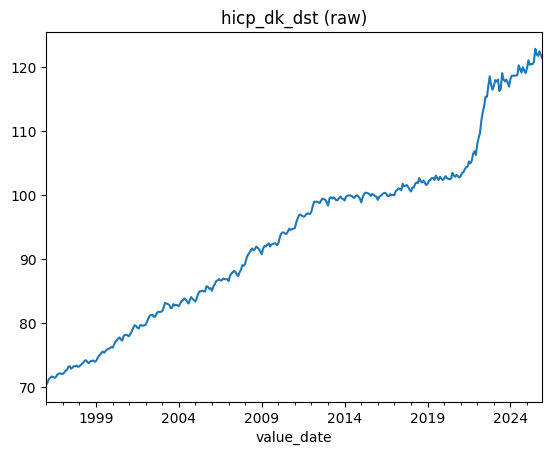

In [15]:
# Pick a series to test transformations on
test_series_name = "hicp_dk_dst"
test_df = df_dedup[df_dedup["internal_series_name"] == test_series_name].copy()
test_series = test_df.set_index("value_date")["value"].sort_index()

print(f"Test series: {test_series_name}")
print(f"Length: {len(test_series)}, Range: {test_series.index.min()} to {test_series.index.max()}")
test_series.plot(title=f"{test_series_name} (raw)");

In [16]:
t = Transformer()

for tfm in ["none", "log", "diff", "12m_diff", "log_diff"]:
    transformed = t.apply_transformation(test_series, tfm)
    print(f"{tfm:12s} -> len={len(transformed)}, NaN={transformed.isna().sum()}, "
          f"mean={transformed.dropna().mean():.4f}")

none         -> len=360, NaN=0, mean=93.8219
log          -> len=360, NaN=0, mean=4.5306
diff         -> len=360, NaN=1, mean=0.1421
12m_diff     -> len=360, NaN=12, mean=1.7155
log_diff     -> len=360, NaN=1, mean=0.0015


## 6. Test LagFeatureBuilder

In [20]:
lag_df = LagFeatureBuilder.create_lag_features(
    series=test_series,
    n_lags=3,
    horizon=6,
    publication_lag=1,
    feature_name="hicp",
)

print(f"Columns: {lag_df.columns.tolist()}")
print(f"Shape: {lag_df.shape}")
lag_df.dropna().head()

Columns: ['hicp_L7', 'hicp_L8', 'hicp_L9']
Shape: (360, 3)


,hicp_L7,hicp_L8,hicp_L9
value_date,,,
1996-10-01,71.3,70.8,70.4
1996-11-01,71.5,71.3,70.8
1996-12-01,71.7,71.5,71.3
1997-01-01,71.6,71.7,71.5
1997-02-01,71.5,71.6,71.7


## 7. Test full DataTransformer pipeline

In [21]:
config = ModelConfig.from_yaml(CONFIG_PATH)
config.validate()

print(f"Target: {config.target.internal_series_name} ({config.target.transformation})")
print(f"Features: {len(config.features)}")
print(f"Horizons: {config.model.horizons}")

Target: hicp_dk_dst (12m_diff)
Features: 12
Horizons: [1, 3, 6, 12, 18, 24]


In [22]:
dt = DataTransformer(config, DATA_PATH)

horizon = 6
result = dt.prepare_data(horizon=horizon)

print(f"Horizon: {horizon}")
print(f"X shape: {result.X.shape}")
print(f"y shape: {result.y.shape}")
print(f"Features: {result.feature_names}")
print(f"Date range: {result.dates.min()} to {result.dates.max()}")
print(f"Metadata: {result.metadata}")

Horizon: 6
X shape: (210, 85)
y shape: (210,)
Features: ['industrial_production_index_dk_dst_L8', 'industrial_production_index_dk_dst_L9', 'industrial_production_index_dk_dst_L10', 'industrial_production_index_dk_dst_L11', 'industrial_production_index_dk_dst_L12', 'industrial_production_index_dk_dst_L13', 'unemployment_rate_dk_eurostat_L7', 'unemployment_rate_dk_eurostat_L8', 'unemployment_rate_dk_eurostat_L9', 'unemployment_rate_dk_eurostat_L10', 'unemployment_rate_dk_eurostat_L11', 'unemployment_rate_dk_eurostat_L12', 'unemployment_rate_dk_eurostat_L13', 'unemployment_rate_dk_eurostat_L14', 'unemployment_rate_dk_eurostat_L15', 'unemployment_rate_dk_eurostat_L16', 'unemployment_rate_dk_eurostat_L17', 'unemployment_rate_dk_eurostat_L18', 'central_gov_debt_dk_L9', 'central_gov_debt_dk_L10', 'central_gov_debt_dk_L11', 'central_gov_debt_dk_L12', 'ppi_commodities_manufacturing_dk_dst_L7', 'ppi_commodities_manufacturing_dk_dst_L8', 'ppi_commodities_manufacturing_dk_dst_L9', 'ppi_commodities

In [23]:
# Check for NaN/inf in output
print(f"X NaN: {np.isnan(result.X).sum()}")
print(f"X inf: {np.isinf(result.X).sum()}")
print(f"y NaN: {np.isnan(result.y).sum()}")
print(f"y inf: {np.isinf(result.y).sum()}")

X NaN: 0
X inf: 0
y NaN: 0
y inf: 0


In [28]:
result.X

array([[-1.6       ,  4.7       ,  4.4       , ...,  2.97081905,
         2.86140002,  2.83121724],
       [ 1.3       , -1.6       ,  4.7       , ...,  3.3024419 ,
         2.97081905,  2.86140002],
       [ 0.5       ,  1.3       , -1.6       , ...,  3.19167275,
         3.3024419 ,  2.97081905],
       ...,
       [14.2       , 20.2       ,  3.        , ...,  2.9622526 ,
         2.86781665,  2.90110261],
       [ 6.7       , 14.2       , 20.2       , ...,  2.90199652,
         2.9622526 ,  2.86781665],
       [11.2       ,  6.7       , 14.2       , ...,  2.74420318,
         2.90199652,  2.9622526 ]], shape=(210, 85))

In [ ]:
x_stats = pd.DataFrame(result.X, columns=result.feature_names).agg(["mean", "std"]).T
x_stats

In [24]:
# Test with vintage date
result_vintage = dt.prepare_data(horizon=6, as_of_date=pd.Timestamp("2023-01-01"))
print(f"Vintage X shape: {result_vintage.X.shape}")
print(f"Vintage date range: {result_vintage.dates.min()} to {result_vintage.dates.max()}")

Vintage X shape: (174, 85)
Vintage date range: 2008-01-01 00:00:00 to 2022-06-01 00:00:00


In [ ]:
# Test across all horizons
for h in config.model.horizons:
    r = dt.prepare_data(horizon=h)
    print(f"h={h:2d}: X={str(r.X.shape):15s} y={str(r.y.shape):10s} "
          f"dates={r.dates.min().date()} to {r.dates.max().date()}")

In [25]:
# Visualize feature matrix
feature_df = pd.DataFrame(result.X, columns=result.feature_names, index=result.dates)
feature_df.describe()

,industrial_production_index_dk_dst_L8,industrial_production_index_dk_dst_L9,industrial_production_index_dk_dst_L10,industrial_production_index_dk_dst_L11,industrial_production_index_dk_dst_L12,industrial_production_index_dk_dst_L13,unemployment_rate_dk_eurostat_L7,unemployment_rate_dk_eurostat_L8,unemployment_rate_dk_eurostat_L9,unemployment_rate_dk_eurostat_L10,...,industrial_production_us_L12,cboe_volatility_index_L6,cboe_volatility_index_L7,cboe_volatility_index_L8,cboe_oil_volatility_index_L6,cboe_oil_volatility_index_L7,cboe_oil_volatility_index_L8,stoxx_europe_50_vix_L6,stoxx_europe_50_vix_L7,stoxx_europe_50_vix_L8
count,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,...,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000
mean,2.781905,2.750952,2.740000,2.670476,2.581429,2.577143,0.015238,0.010952,0.014286,0.010952,...,0.089164,2.929537,2.929253,2.928367,3.588248,3.587537,3.585794,3.073905,3.074463,3.074126
std,7.229800,7.207467,7.203184,7.162387,7.058904,7.058922,0.509767,0.505211,0.501467,0.500549,...,4.777118,0.350466,0.350625,0.351254,0.340274,0.340730,0.341352,0.320608,0.320132,0.320352
min,-18.900000,-18.900000,-18.900000,-18.900000,-18.900000,-18.900000,-1.700000,-1.700000,-1.700000,-1.700000,...,-17.712100,2.315053,2.315053,2.315053,2.814096,2.814096,2.814096,2.499100,2.499100,2.499100
25%,-0.475000,-0.475000,-0.475000,-0.475000,-0.475000,-0.475000,-0.300000,-0.300000,-0.300000,-0.300000,...,-1.503625,2.654113,2.654113,2.653317,3.372897,3.368067,3.365743,2.860217,2.861998,2.859619
50%,2.550000,2.550000,2.550000,2.350000,2.250000,2.200000,0.000000,0.000000,0.000000,0.000000,...,1.348500,2.877566,2.877566,2.877566,3.572198,3.572198,3.570451,3.063215,3.063215,3.063215
75%,5.875000,5.800000,5.800000,5.775000,5.625000,5.625000,0.300000,0.300000,0.300000,0.300000,...,2.866425,3.138859,3.138859,3.138859,3.783524,3.783524,3.783524,3.267938,3.267938,3.267938
max,24.700000,24.700000,24.700000,24.700000,24.700000,24.700000,1.500000,1.500000,1.500000,1.500000,...,13.996800,4.137866,4.137866,4.137866,5.097745,5.097745,5.097745,4.147443,4.147443,4.147443
